In [299]:
from arch.univariate import ARX, ZeroMean # Drift model
from arch.univariate import ConstantVariance, FixedVariance, ARCH, GARCH, EGARCH, EWMAVariance, RiskMetrics2006 # Volatility models
from arch.univariate import Normal, StudentsT, SkewStudent, GeneralizedError # Distributions
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [301]:
df = pd.read_csv('../data/clean_data.csv', parse_dates=['date']).set_index('date')
df['FX/Vix'] = df['FX log returns']/df['vix']

In [302]:
# Prepare the list of variables
microstructure = [
    'Bid ask abs', 
    'Min max abs',
    'Forward points first difference']

cip = ['Interbank rate vs Libor']

eurusd = ['EURUSD log returns']

external_shocks = ['VIX first diff', 'Oil prices log returns']

prev_interventions = ['FX intervention dummy lag']


# List of models
models_l = {'Microstructure': microstructure,
            'CIP': microstructure + cip,
            'Dollar move' : microstructure + cip + eurusd,
            'Risk Appetite': microstructure + cip + eurusd + external_shocks,
            'Baseline' : microstructure + cip + eurusd + external_shocks + prev_interventions
            }

fx_cols = ['FX intervention in USD', 'FX level', 'FX log returns', 'FX/Vix']
transformed_variables = fx_cols + models_l['Baseline']

start_date = df.index[df[transformed_variables].count(axis=1) ==len(transformed_variables)][0]

df_tranformed = df.loc[df.index>=start_date, transformed_variables].fillna(0)

In [306]:
def plot_forecast(res_forecast):
    # Create the first plot with blue axis
    fig, ax1 = plt.subplots()
    ax1.plot(res_forecast.cond_mean, color='b', alpha=0.8)
    ax1.set_ylabel('Conditional Mean', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xlabel('Date')
    ax1.set_title('Forecast')

    # Create the second plot with red axis
    ax2 = ax1.twinx()
    ax2.plot(res_forecast.cond_var, color='orange')
    ax2.set_ylabel('Conditional Variance', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.show()

In [304]:
def KS_distrib_test(data, cdf, threshold = 0.05, verbose=True) -> bool:
    # Compute the KS statistics (in case of need)
    # The null hypothesis is that the two distributions are identical
    # Reject the null hypothesis if the pvalue < threshold
    ks_stats = stats.kstest(data, cdf)
    reject = (ks_stats.pvalue < threshold)
    PassFail = 'Fail' if reject else 'Pass'
    spec = 'not'
    m1= '#'*10+ ' Kolmogorov Smirnov PIT test ' + '#'*10
    m2 = f'PIT test {PassFail} !!!'
    m3 = f'Distribution is {spec} well specified'
    m4 = f'The conditional CDF of Normalized True Values are {spec} a Uniform'
    
    if verbose:
        print(m1+'\n'+m2+'\n'+m3+'\n'+m4) 
    
    return not reject

In [307]:
def qqplot_cdf(data, ppf, title = 'QQ Plot') -> None:
    """
    Plot a QQ plot for a given CDF function and data.

    Parameters:
    ppf (callable): A function that represents the PPF of the theoretical distribution.
    data (array-like): An array of sample data.

    Returns:
    None
    """
    # Calculate percentiles of the sample data
    percentiles = np.linspace(.1, 99, 99)

    # Calculate theoretical quantiles for each percentile of the sample data
    sampling_quantiles = np.array([np.percentile(data, p) for p in percentiles])
    theoretical_quantiles = ppf(percentiles/100)

    # Plot the sample quantiles against the theoretical quantiles
    plt.scatter(theoretical_quantiles, sampling_quantiles)
    plt.plot(theoretical_quantiles, theoretical_quantiles, color='r')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.title('QQ Plot')
    plt.show()

In [308]:
def KS_PIT_test(pits, threshold = 0.05, verbose=True) -> bool:
    # Compute the KS statistics (in case of need)
    # The null hypothesis is that the two distributions are identical
    # Reject the null hypothesis if the pvalue < threshold
    ks_stats = stats.kstest(pits, 'uniform')
    reject = (ks_stats.pvalue < threshold)
    PassFail = 'Fail' if reject else 'Pass'
    spec = 'not'
    m1= '#'*10+ ' Kolmogorov Smirnov PIT test ' + '#'*10
    m2 = f'PIT test {PassFail} !!!'
    m3 = f'Distribution is {spec} well specified'
    m4 = f'The conditional CDF of Normalized True Values are {spec} a Uniform'
    
    if verbose:
        print(m1+'\n'+m2+'\n'+m3+'\n'+m4) 
    
    return not reject

In [309]:
def RS_PIT_test(pits, threshold=0.05, part_distribution='Tails', plot=True, verbose=True) -> bool:
    '''
    Rossi and Shekopysan JoE 2019 PIT test
    
    Parameters:
        pits: series or list: The conditional CDF of Normalized True Values 
        threshold: float. statistical test threshold. Values available [0.01, 0.05, 0.1]
        part_distribution: str. Part of the distribution on which the specification test is conducted
                whole Distribution                [0; 0:25]
                Left Tail                         [0; 0:25]
                Left Half                         [0; 0:50]
                Right Half                        [0:50; 1]
                Right Tail                        [0:75; 1]
                Center                           [0:25; 0:75]
                Tails                        [0; 0:25] + [0:75; 1]
        plot: bool. If True, plot the empirical cuulative density function of normalized true values and compare them visually with the uniform distribution
        The distribution is well specified if and only if the empirical plot do not exceed the Rossi and Shekopysan confidence interval
    
    '''
    
    # Data work (note that the pit are computed by default)
    support = np.arange(0, 1, 0.01)

    # Compute the ecdf on the pits
    ecdf = ECDF(pits)
    # Fit it on the support
    pit_line = ecdf(support)
    uniform_line = stats.uniform.cdf(support)
    
    # Confidence intervals based on Rossi and Shekopysan JoE 2019
    confidence_interval = pd.DataFrame({
        'part of distribution': ['whole Distribution', 'Left Tail', 'Left Half', 'Right Half', 'Right Tail', 'Center', 'Tails'],
        'Interval': ['[0; 0:25]', '[0; 0:25]', '[0; 0:50]', '[0:50; 1]', '[0:75; 1]', '[0:25; 0:75]', '[0; 0:25] + [0:75; 1]'],
        0.01: [1.61, 1.24, 1.54, 1.53, 1.24, 1.61, 1.33],
        0.05: [1.34, 1.00, 1.26, 1.25, 1.00, 1.33, 1.10],
        0.10: [1.21, 0.88, 1.12, 1.12, 0.88, 1.19, 0.99]
    }).set_index('part of distribution')
    
    available_thresholds = [0.01, 0.05, 0.1] 
    available_part_distrib = confidence_interval.index
    assert threshold in available_thresholds, f'Test only available on {available_thresholds}'
    assert part_distribution in available_part_distrib, f"part_distribution should belong to one of the following options {available_part_distrib}"
    
    kp = confidence_interval.loc[part_distribution, threshold]/np.sqrt(len(pits))          
    breach = any(abs(pit_line - uniform_line) > kp)
    is_well_specified = not breach
    PassFail='Fail' if breach else 'Pass';
    spec = 'not' if breach else '';
    
    m1= '#'*10+' Rossi and Shekopysan JoE 2019 PIT test ' +'#'*10
    m2 = f'PIT test {PassFail} !!!'
    m3 = f'Distribution is {spec} well specified'
    m4 = f'The conditional CDF of Normalized True Values are {spec} a Uniform'
    
    if verbose:
        print(m1+'\n'+m2+'\n'+m3+'\n'+m4)        
    
    if plot:
        ci_u = [x+kp for x in support]
        ci_l = [x-kp for x in support]
        
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        ax.plot(support, pit_line, color='blue', label='Empirical CDF', lw=2)
        ax.plot(support, uniform_line, color='red', label='Theoretical CDF')
        ax.plot(support, ci_u, color='red', label=f'{int(threshold*100)}% critical values', linestyle='dashed')
        ax.plot(support, ci_l, color='red', linestyle='dashed')
        ax.legend()
        ax.set_xlabel('Quantiles', labelpad=20)
        ax.set_ylabel('Cumulative probability', labelpad=20)
        ax.set_title(('Out-of-sample conditional density:\n'
                      'Probability Integral Transform (PIT) test'), y=1.02)
        plt.show()
    
    return is_well_specified

In [310]:
def get_cdf_ppf_et(mod, res):
    #### CDF and sampling estimation
    # Important: the standardized distribution does NOT change over time. 
    # Parameters are fixed, The conditional mean and volatility change
    # Define functions associated with conditional distribution 
    
    if mod.distribution.name=='Normal': # No parameters
        cond_ppf = lambda q: mod.distribution.ppf(q)
        cond_cdf = lambda v: mod.distribution.cdf(v)
    else:
        dist_params = res.params[-mod.distribution.num_params:]
        cond_ppf = lambda q: mod.distribution.ppf(q, dist_params)
        cond_cdf = lambda v: mod.distribution.cdf(v, dist_params)
        
            
    return cond_cdf, cond_ppf

### Divide and Conquer Method
Split the Mean specification from the volatility specification

In [311]:
# Variable Declarations
split_date = '2020-01-01'
depvar = 'FX log returns' # 'FX/Vix'
exog_l = models_l['Baseline']


exog_fcast_d = {var: df_tranformed.loc[:, [var]].values for var in exog_l}
horizon=1
fmethod='analytic' #'simulations', 'bootstrap'

vol_spec_l = [ConstantVariance(), ARCH(1), EGARCH(1,1,1), GARCH(1), GARCH(1,1), EWMAVariance(None), RiskMetrics2006()]
vol_labels_l = ['Constant', 'ARCH', 'EGARCH', 'GARCH', 'gjrGARCH', 'EWMA', 'RiskMetric']

# List of error distribution
errdist_l = [Normal(), StudentsT(), SkewStudent(), GeneralizedError()]
errdist_labels_l = ['Normal', 'StudentT', 'SkewStudent', 'GeneralizedError']

th = 0.05

##### Mean model

In [359]:
mean_res.forecast()

Signature:
mean_res.forecast(
    params: 'Optional[ArrayLike1D]' = None,
    horizon: 'int' = 1,
    start: 'Union[int, DateLike]' = None,
    align: "Literal['origin', 'target']" = 'origin',
    method: 'ForecastingMethod' = 'analytic',
    simulations: 'int' = 1000,
    rng: 'Optional[Callable[[Union[int, Tuple[int, ...]]], Float64Array]]' = None,
    random_state: 'Optional[np.random.RandomState]' = None,
    *,
    reindex: 'Optional[bool]' = None,
    x: 'Union[None, Dict[Label, ArrayLike], ArrayLike]' = None,
) -> 'ARCHModelForecast'
Docstring:
Construct forecasts from estimated model

Parameters
----------
params : ndarray, optional
    Alternative parameters to use.  If not provided, the parameters
    estimated when fitting the model are used.  Must be identical in
    shape to the parameters computed by fitting the model.
horizon : int, optional
   Number of steps to forecast
start : {int, datetime, Timestamp, str}, optional
    An integer, datetime or str indicating the fir

In [358]:
# it can be any model. Here we chose an ARX 
mean_mod = ARX(df_tranformed[depvar], 
               x = df_tranformed[exog_l], 
               lags=[1, 8], 
              volatility=ConstantVariance(), 
              distribution =Normal())
mean_res = mean_mod.fit(disp="off")
print(mean_res.summary())

                    AR-X - Constant Variance Model Results                    
Dep. Variable:         FX log returns   R-squared:                       0.287
Mean Model:                      AR-X   Adj. R-squared:                  0.285
Vol Model:          Constant Variance   Log-Likelihood:               -31378.4
Distribution:                  Normal   AIC:                           62780.9
Method:            Maximum Likelihood   BIC:                           62860.6
                                        No. Observations:                 5675
Date:                Thu, Apr 13 2023   Df Residuals:                     5664
Time:                        11:28:19   Df Model:                           11
                                             Mean Model                                            
                                      coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------------------

##### Extract residuals to model separately

In [314]:
epsilon = mean_res.resid.dropna()
moments = {'mean': epsilon.mean(), 
           'std':epsilon.std(), 'variance':epsilon.var(),
           'skew':epsilon.skew(), 
          'kurt':epsilon.kurt()}
for k, v in moments.items():
    print(f'{k} =  {np.round(v,2)}')
print('As expected residuals have high skewness and fat tails')

mean =  0.0
std =  60.97
variance =  3717.39
skew =  0.13
kurt =  8.82
As expected residuals have high skewness and fat tails


##### Model residuals with GARCH

In [325]:
vol_mod = ZeroMean(epsilon, volatility=GARCH(1,1,1), distribution=SkewStudent())
vol_res = vol_mod.fit(disp='off')
print(vol_res.summary())

                           Zero Mean - GJR-GARCH Model Results                           
Dep. Variable:                             resid   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -30474.6
Distribution:      Standardized Skew Student's t   AIC:                           60961.1
Method:                       Maximum Likelihood   BIC:                           61001.0
                                                   No. Observations:                 5675
Date:                           Thu, Apr 13 2023   Df Residuals:                     5675
Time:                                   10:25:31   Df Model:                            0
                               Volatility Model                               
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------

In [365]:
mean_res.conditional_volatility.dropna()

date
1999-01-14    60.965058
1999-01-15    60.965058
1999-01-18    60.965058
1999-01-19    60.965058
1999-01-20    60.965058
                ...    
2020-10-08    60.965058
2020-10-09    60.965058
2020-10-12    60.965058
2020-10-13    60.965058
2020-10-14    60.965058
Name: cond_vol, Length: 5675, dtype: float64

In [374]:
lags = [1, 8]
final_model_spec = ARX(df_tranformed[depvar], 
                       x = df_tranformed[exog_l], 
                       lags=lags, 
                       volatility=GARCH(1,1,1),
                       distribution=SkewStudent())
params=pd.concat([mean_res.params.drop('sigma2'), vol_res.params])
final_model = final_model_spec.fix(params=params, first_obs=max(lags))
exog_fcast_d = {}
for var in exog_l:
    exog_fcast_d[var] = df_tranformed.loc[:, [var]].values
forecasts = final_model.forecast(horizon=1,x=exog_fcast_d)

/home/ubuntu/Documents/Projects/varfxi/.venv/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [378]:
final_model.pvalue

AttributeError: 'ARCHModelFixedResult' object has no attribute 'pvalue'

In [370]:
final_model_spec.f

Signature:
final_model_spec.fix(
    params: 'Union[Sequence[float], ArrayLike1D]',
    first_obs: 'Union[int, DateLike]' = None,
    last_obs: 'Union[int, DateLike]' = None,
) -> 'ARCHModelFixedResult'
Docstring:
Allows an ARCHModelFixedResult to be constructed from fixed parameters.

Parameters
----------
params : {ndarray, Series}
    User specified parameters to use when generating the result. Must
    have the correct number of parameters for a given choice of mean
    model, volatility model and distribution.
first_obs : {int, str, datetime, Timestamp}
    First observation to use when fixing model
last_obs : {int, str, datetime, Timestamp}
    Last observation to use when fixing model

Returns
-------
results : ARCHModelFixedResult
    Object containing model results

Notes
-----
Parameters are not checked against model-specific constraints.
File:      ~/Documents/Projects/varfxi/.venv/lib/python3.9/site-packages/arch/univariate/base.py
Type:      method

ValueError: Length of values (5667) does not match length of index (5675)

In [352]:
final_model.arch_lm_test()

ValueError: Length of values (5675) does not match length of index (5683)

ValueError: Length of values (5675) does not match length of index (5683)

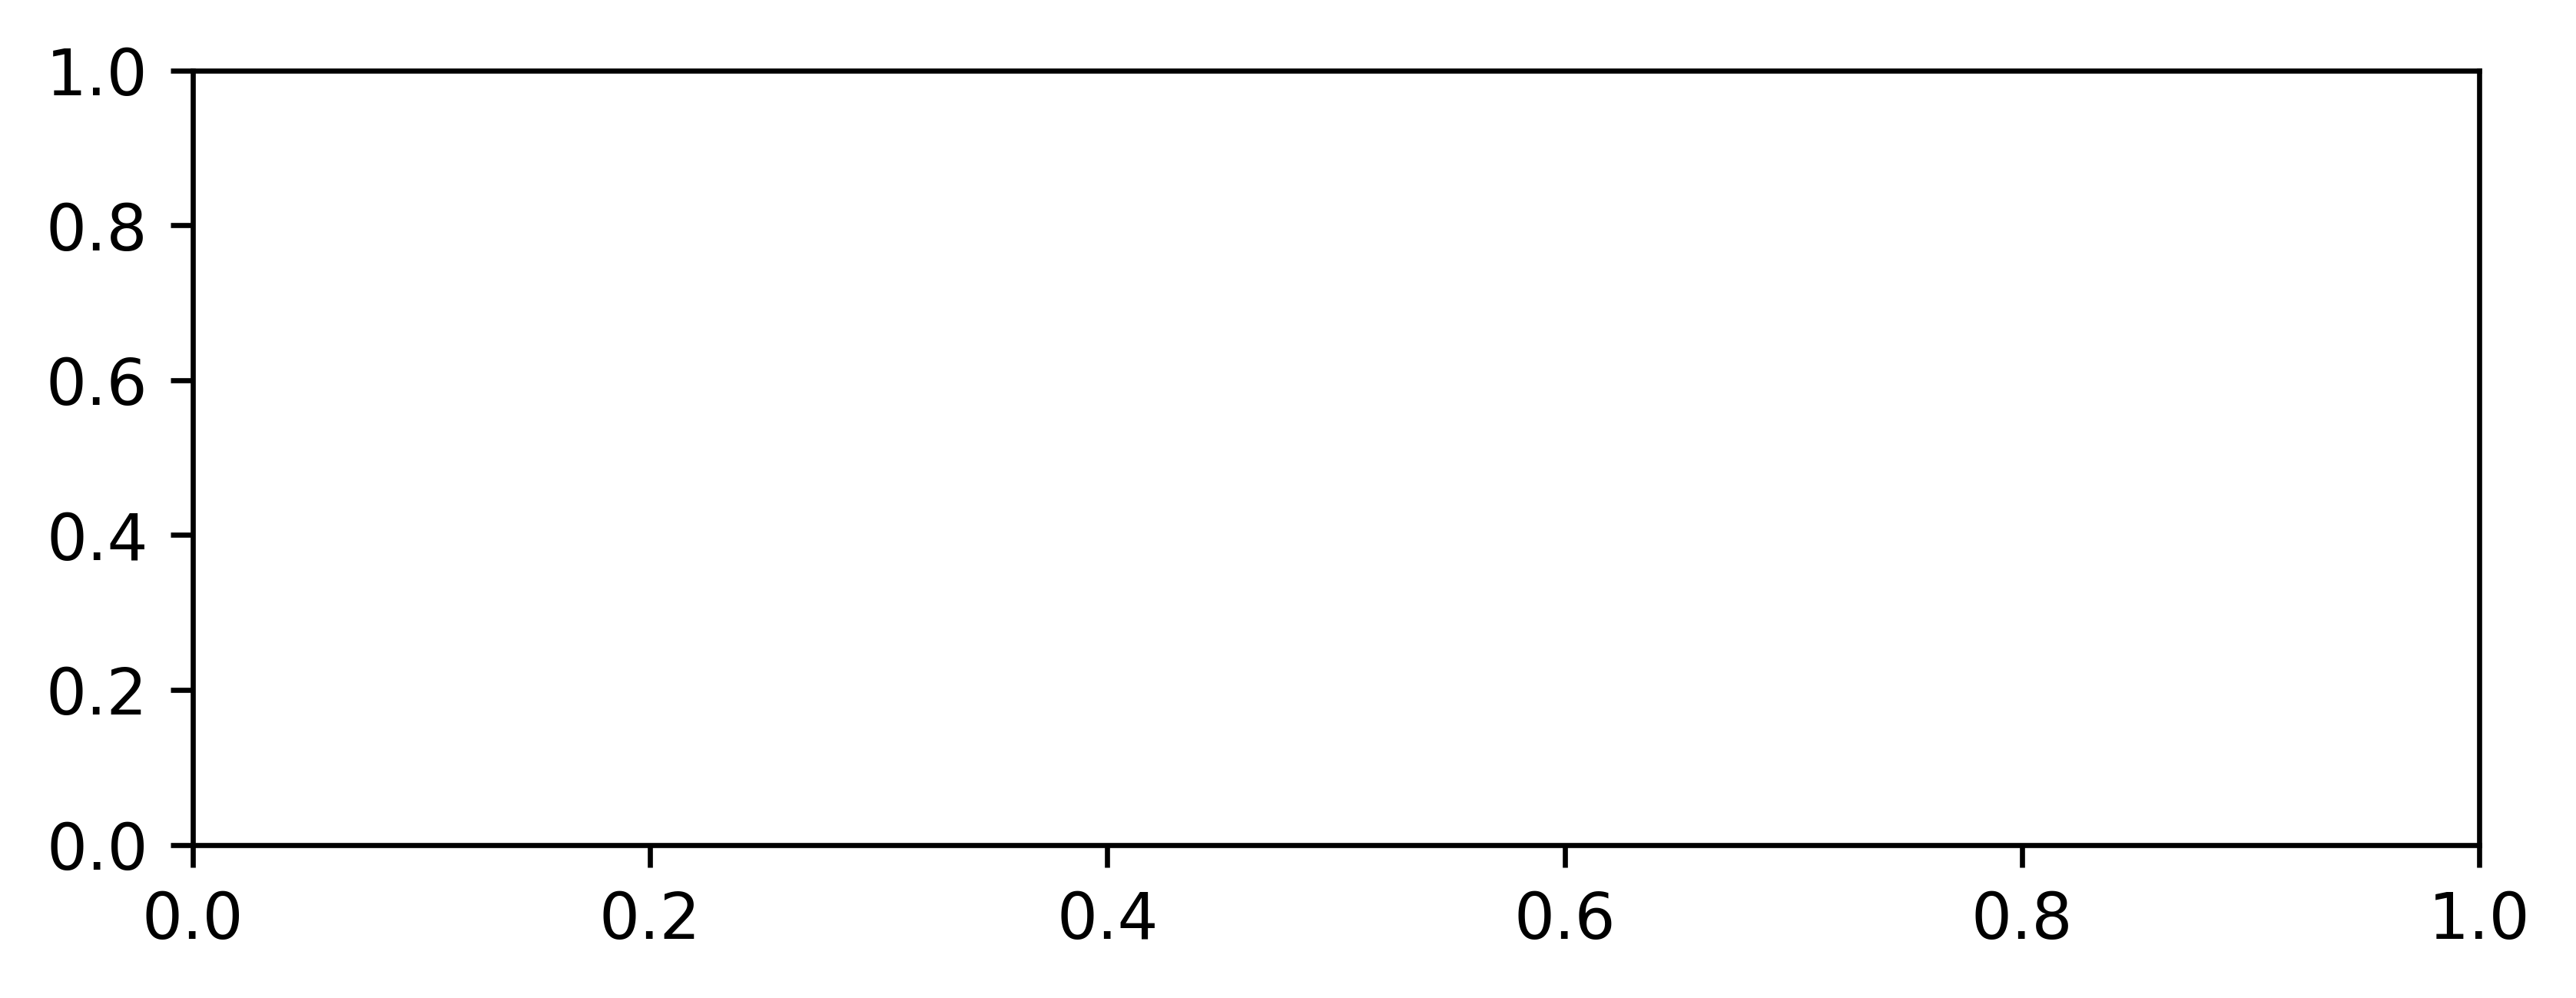

In [345]:
final_model.plot()

In [42]:
# create the list of quantiles
q_l = [0.01] + [round(x,3) for x in np.arange(0.025,1,0.025)] + [0.99]
cond_quant_labels_l = [f"cond_quant_{q}" for q in q_l]
# compute the PPF for all Quantiles
err_cond_quant = cond_ppf(q_l)

for var in cond_quant_labels_l: dfor[var] = np.nan
dfor[cond_quant_labels_l] = (dfor[['cond_mean']].values + (dfor[['cond_vol']].values * err_cond_quant[None, :]))

# Sampling the error terms and deriving the values for y in a dataframe

# create the standardized error distribution sampler
err_sampler = vol_mod.distribution.simulate(dist_params)
sample_size = 1000
err_sample = err_sampler(sample_size)

# Rescale to get a sample for the true time series
cond_vol_reshape = cond_vol.values.reshape((-1, 1))  # shape (5675, 1)
err_sample_reshape = err_sample.reshape((1, -1))  # shape (1, 1000)
cond_mean_reshape = cond_mean.values.reshape((-1, 1))

sample = pd.DataFrame(cond_mean_reshape + np.dot(cond_vol_reshape, err_sample_reshape),
                      columns=range(sample_size),
                      index=dfor.index)

$\ln f\left(x\right)=-\frac{1}{2}\left(\ln2\pi+\ln\sigma^{2}  +\frac{x^{2}}{\sigma^{2}}\right)$

$\ln\Gamma\left(\frac{\nu+1}{2}\right) -\ln\Gamma\left(\frac{\nu}{2}\right) -\frac{1}{2}\ln(\pi\left(\nu-2\right)\sigma^{2}) -\frac{\nu+1}{2}\ln(1+x^{2}/(\sigma^{2}(\nu-2)))$

In [69]:
rv = {}
dfor['pit_true_val'] = np.nan
for date in dfor.index:
    param_fit = scipy_dist.fit(sample.loc[date])
    rv[date] = scipy_dist(*param_fit)
    dfor.loc[date, 'pit_true_val'] = rv[date].cdf( dfor.loc[date, 'true_val'])

########## Rossi and Shekopysan JoE 2019 PIT test ##########
PIT test Fail !!!
Distribution is not well specified
The conditional CDF of Normalized True Values are not a Uniform


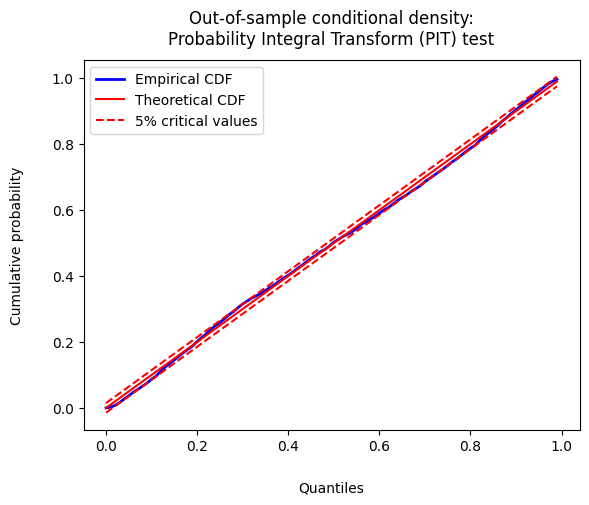

########## Kolmogorov Smirnov PIT test ##########
PIT test Pass !!!
Distribution is not well specified
The conditional CDF of Normalized True Values are not a Uniform


True

In [74]:
RS_PIT_test(dfor['pit'].dropna(), threshold = th, part_distribution='Tails')
KS_PIT_test(dfor['pit'].dropna(), threshold = th)    

### Zig-Zag Method
Split Mean estimation from volatility estimation

In [34]:
# Variable Declarations
start_date = '2020-01-01'
exog_l = models_l['Baseline']
exog_fcast_d = {var: df_tranformed.loc[:, [var]].values for var in exog_l}
horizon=1
fmethod='analytic' #'simulations', 'bootstrap'


for depvar in ['FX/Vix', 'FX log returns']:
    exog_l = models_l['Baseline']
    start_date = '2020-01-01'

    exog_fcast_d = {var: df_tranformed.loc[:, [var]].values for var in exog_l}
    horizon=1
    fmethod='analytic' #'simulations', 'bootstrap'

    params = {}
    for i in range(3):
        if i==0:
            fv = ConstantVariance()
        else:
            # Create the fixed variance
            cond_var = (vol_res.conditional_volatility**2.0)
            variance = pd.Series(np.ones(len(df_tranformed))*cond_var.mean(), index=df_tranformed.index)
            variance.loc[cond_var.index] = cond_var
            variance = variance.fillna(variance.mean())    
            fv = FixedVariance(variance, unit_scale=True)

        # Re-train the main model with the previous Conditional Variance
        mean_mod = ARX(df_tranformed[depvar], 
                  x = df_tranformed[exog_l], 
                  lags=[1, 8],
                  volatility=fv,
                       distribution = SkewStudent())
        mean_res = mean_mod.fit(disp="off")

        vol_mod = ZeroMean(mean_res.resid.dropna(),
                           volatility=GARCH(p=1, o=1, q=1),
                           distribution = SkewStudent()
                          )
        vol_res = vol_mod.fit(disp="off")


        params[f"iteration_{i}"] = pd.concat([
            pd.concat([mean_res.params, vol_res.params]),
            pd.concat([mean_res.pvalues, vol_res.pvalues])
        ], axis=1, keys=['params', 'pvalues'])

    params_df = pd.concat(params.values(), keys = params.keys(), axis=1)
    display( np.round(params_df, 3))
    print(mean_res.summary())
    print(vol_res.summary())
    mean_res.plot(); plt.show()
    
#     #Forecast
#     forecast_vars = pd.concat([df_tranformed[depvar].shift(lag).rename(f'FX l...rns[{lag}]') for lag in [1, 8]],axis=1)
#     forecast_vars['Const'] = 1
#     forecast_vars = pd.concat([forecast_vars, df_tranformed[exog_l]], axis=1).dropna()
#     cond_mean = (mean_res.params*forecast_vars).sum(axis=1)
    
#     cond_vol = vol_res.conditional_volatility
#     cond_var = cond_vol**2
    
#     res_forecast = pd.concat([
#         cond_mean,
#         cond_vol,
#         cond_var
#     ], axis = 1, keys = ['Mean', 'Volatility', 'Variance'])
    
#     plot_forecast(res_forecast)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects